### Loading library and data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, PowerTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam, RMSprop

train= pd.read_csv("Google_Stock_Price_Train.csv")
test= pd.read_csv("Google_Stock_Price_Test.csv")
columns=['Open', 'High', 'Low', 'Close', 'Volume']

### Data pre-processing

In [31]:
def data_preprocessing(df, test, scaler=StandardScaler(), N=30, M=1):
    # Changing data types
    df=df.copy()
    test=test.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Close']=df['Close'].str.replace(',','')
    df['Close']= df['Close'].astype('float')
    df['Volume']=df['Volume'].str.replace(',','')
    df['Volume']= df['Volume'].astype('int')
    df = df.sort_values(by='Date').reset_index(drop=True)
    
    test['Date'] = pd.to_datetime(test['Date'])
    test['Volume']=test['Volume'].str.replace(',','')
    test['Volume']= test['Volume'].astype('int')
    test = test.sort_values(by='Date').reset_index(drop=True)

    # Normalize the data
    df = scaler.fit_transform(df.drop(columns=['Date']))
    test = scaler.transform(test.drop(columns=['Date']))

    # Sequences for RNN
    def create_sequences(data, n_steps, m_steps):
        X, y = [], []
        for i in range(len(data) - n_steps - m_steps + 1):
            X.append(data[i:i + n_steps, :])
            y.append(data[i + n_steps:i + n_steps + m_steps, :])
        return np.array(X), np.array(y)

    def create_test_sequences(test,df, n_steps, m_steps):
        test=test.tolist()
        df=df.tolist()
        X, y = [], []
        for i in range(len(test)-m_steps+1):
            X.append(df[-n_steps+i:]+test[:i])
            y.append(test[i:m_steps+i])
        return np.array(X),np.array(y)

    X, y = create_sequences(df, N, M)
    X_test, y_test = create_test_sequences(test, df, N, M)

    # Spliting into training and validation
    X_train=X[:982]
    X_val=X[982:]
    y_train=y[:982]
    y_val=y[982:]
    return X_train, X_val, X_test, y_train, y_val, y_test

## RNN

### Base RNN

Epoch 1/100
31/31 [==============================] - 1s 19ms/step - loss: 0.4566 - val_loss: 0.1493
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.1519 - val_loss: 0.0603
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.1315 - val_loss: 0.0438
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.1220 - val_loss: 0.0368
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 0.1150 - val_loss: 0.0361
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 0.1138 - val_loss: 0.0315
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 0.1103 - val_loss: 0.0314
Epoch 8/100
31/31 [==============================] - 0s 13ms/step - loss: 0.1087 - val_loss: 0.0340
Epoch 9/100
31/31 [==============================] - 0s 14ms/step - loss: 0.1081 - val_loss: 0.0285
Epoch 10/100
31/31 [==============================] - 0s 13ms/step - loss: 0.1058 - val_loss: 0.0302

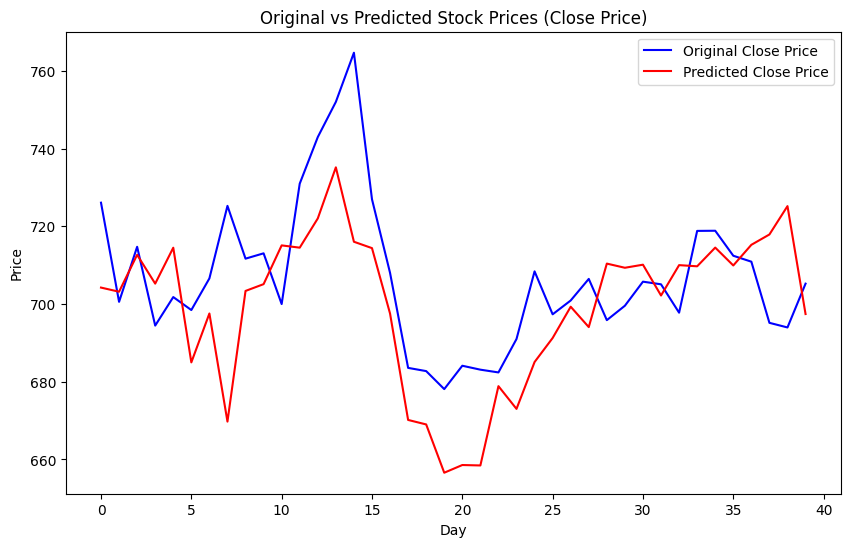

MSE:  232.80763845141192
RMSE:  15.258035209403992


In [36]:
scaler=StandardScaler()
M=1
N=30

X_train, X_val, X_test, y_train, y_val, y_test = data_preprocessing(train,test, scaler=scaler, M=M, N=N)

# Build the RNN model
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(N, 5)),
    Dense(M * 5)
])

model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)


# Train the model
history = model.fit(
    X_train, y_train.reshape(y_train.shape[0], -1),
    validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


# Predictions
y_pred = model.predict(X_val)
y_pred = y_pred.reshape(y_pred.shape[0], M, 5)
y_val_inv = scaler.inverse_transform(pd.DataFrame(y_val.reshape(-1, 5), columns=columns))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 5))

# Plot original vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv[:40, 3], label="Original Close Price", color='blue')
plt.plot(y_pred_inv[:40, 3], label="Predicted Close Price", color='red')
plt.title("Original vs Predicted Stock Prices (Close Price)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()
mse = mean_squared_error(y_val_inv[:, 3], y_pred_inv[:, 3])
rmse = math.sqrt(mse)
print("MSE: ", mse)
print('RMSE: ', rmse)

### Hyperparameter tuned RNN

Epoch 1/100


C:\Users\dhari\AppData\Local\Temp\ipykernel_108900\107324530.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_rnn_model, verbose=1)


31/31 [==============================] - 1s 21ms/step - loss: 0.4455 - val_loss: 0.1422
Epoch 2/100
31/31 [==============================] - 0s 16ms/step - loss: 0.1332 - val_loss: 0.0348
Epoch 3/100
31/31 [==============================] - 0s 15ms/step - loss: 0.1172 - val_loss: 0.0319
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 0.1121 - val_loss: 0.0285
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.1049 - val_loss: 0.0269
Epoch 6/100
31/31 [==============================] - 0s 13ms/step - loss: 0.1035 - val_loss: 0.0309
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 0.1044 - val_loss: 0.0330
Epoch 8/100
31/31 [==============================] - 0s 14ms/step - loss: 0.1048 - val_loss: 0.0304
Epoch 9/100
31/31 [==============================] - 0s 13ms/step - loss: 0.1034 - val_loss: 0.0310
Epoch 10/100
31/31 [==============================] - 0s 13ms/step - loss: 0.1042 - val_loss: 0.0335
Epoch 11/10

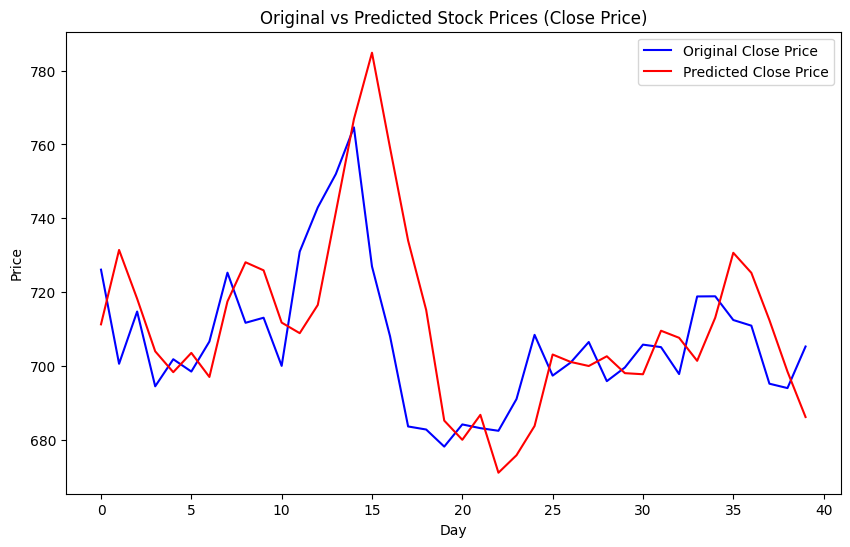

MSE:  187.86902944075348
RMSE:  13.70653236383125


In [44]:
def create_rnn_model(units=50, activation='relu',optimizer='adam',learning_rate=0.001):
    model = Sequential([
        SimpleRNN(units, activation=activation, input_shape=(N, 5)),
        Dense(M * 5)
    ])
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse')
    return model


model = KerasRegressor(build_fn=create_rnn_model, verbose=1)
param_grid = {
    'units': [20, 125 ,150, 175],  
    'batch_size': [32],
    'activation': ['relu','tanh'],
    'optimizer': ['adam','RMSprop'],
    'learning_rate' : [0.01,0.001,0.0001],
    'epochs': [100],
    'callbacks': [EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=[(slice(None), slice(None))])
grid_search.fit(X_train, y_train.reshape(y_train.shape[0], -1), validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))


best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Predictions
y_pred = best_model.predict(X_val)
y_pred = y_pred.reshape(y_pred.shape[0], M, 5)

# Inverse transform predictions and ground truth
y_val_inv = scaler.inverse_transform(pd.DataFrame(y_val.reshape(-1, 5), columns=columns))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 5))

# Plot original vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv[:40, 3], label="Original Close Price", color='blue')
plt.plot(y_pred_inv[:40, 3], label="Predicted Close Price", color='red')
plt.title("Original vs Predicted Stock Prices (Close Price)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()

mse = mean_squared_error(y_val_inv[:, 3], y_pred_inv[:, 3])
rmse = math.sqrt(mse)
print("MSE: ", mse)
print('RMSE: ', rmse)

### Multilayer RNN

Epoch 1/100


C:\Users\dhari\AppData\Local\Temp\ipykernel_119856\3835413173.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_multilayer_rnn, verbose=1)


31/31 [==============================] - 2s 36ms/step - loss: 0.6678 - val_loss: 0.4802
Epoch 2/100
31/31 [==============================] - 1s 29ms/step - loss: 0.3521 - val_loss: 0.0897
Epoch 3/100
31/31 [==============================] - 1s 29ms/step - loss: 0.1965 - val_loss: 0.0799
Epoch 4/100
31/31 [==============================] - 1s 29ms/step - loss: 0.1518 - val_loss: 0.0501
Epoch 5/100
31/31 [==============================] - 1s 29ms/step - loss: 0.1387 - val_loss: 0.0601
Epoch 6/100
31/31 [==============================] - 1s 29ms/step - loss: 0.1318 - val_loss: 0.0379
Epoch 7/100
31/31 [==============================] - 1s 28ms/step - loss: 0.1260 - val_loss: 0.0358
Epoch 8/100
31/31 [==============================] - 1s 30ms/step - loss: 0.1229 - val_loss: 0.0653
Epoch 9/100
31/31 [==============================] - 1s 29ms/step - loss: 0.1192 - val_loss: 0.0416
Epoch 10/100
31/31 [==============================] - 1s 28ms/step - loss: 0.1134 - val_loss: 0.0415
Epoch 11/10

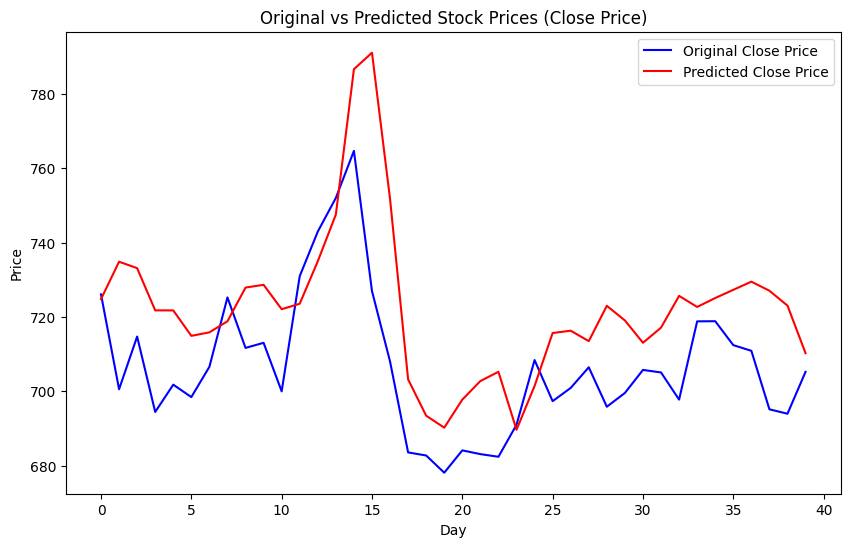

MSE:  290.0924194930302
RMSE:  17.032099679517795


In [44]:
def create_multilayer_rnn(units=50, activation='relu', optimizer='adam', learning_rate=0.001, num_layers=0):
    model = Sequential()
    model.add(SimpleRNN(units, activation=activation, input_shape=(N, 5), return_sequences=True))
    
    for _ in range(num_layers):
        model.add(SimpleRNN(units, activation=activation, return_sequences=True))
    
    model.add(SimpleRNN(units, activation=activation))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(M * 5))
    

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='mse')
    return model


model = KerasRegressor(build_fn=create_multilayer_rnn, verbose=1)


param_grid = {
    'units': [20,50],  
    'activation': ['relu','tanh'],
    'optimizer': ['adam','RMSprop'],
    'learning_rate': [0.01,0.001],  
    'epochs': [100],
    'num_layers': [0,1],
    'callbacks': [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=[(slice(None), slice(None))])
grid_search.fit(X_train, y_train.reshape(y_train.shape[0], -1), validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Predictions
y_pred = best_model.predict(X_val)
y_pred = y_pred.reshape(y_pred.shape[0], M, 5)

y_val_inv = scaler.inverse_transform(pd.DataFrame(y_val.reshape(-1, 5), columns=columns))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 5))

# Plot original vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv[:40, 3], label="Original Close Price", color='blue')
plt.plot(y_pred_inv[:40, 3], label="Predicted Close Price", color='red')
plt.title("Original vs Predicted Stock Prices (Close Price)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()

mse = mean_squared_error(y_val_inv[:, 3], y_pred_inv[:, 3])
rmse = math.sqrt(mse)
print("MSE: ", mse)
print('RMSE: ', rmse)

## LSTM

### Base LSTM

Epoch 1/50
31/31 [==============================] - 1s 12ms/step - loss: 0.5941 - val_loss: 0.8320
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.2592 - val_loss: 0.5765
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.1918 - val_loss: 0.3602
Epoch 4/50
31/31 [==============================] - 0s 5ms/step - loss: 0.1666 - val_loss: 0.2048
Epoch 5/50
31/31 [==============================] - 0s 4ms/step - loss: 0.1534 - val_loss: 0.1300
Epoch 6/50
31/31 [==============================] - 0s 5ms/step - loss: 0.1448 - val_loss: 0.0989
Epoch 7/50
31/31 [==============================] - 0s 5ms/step - loss: 0.1399 - val_loss: 0.0888
Epoch 8/50
31/31 [==============================] - 0s 4ms/step - loss: 0.1359 - val_loss: 0.0730
Epoch 9/50
31/31 [==============================] - 0s 4ms/step - loss: 0.1325 - val_loss: 0.0688
Epoch 10/50
31/31 [==============================] - 0s 4ms/step - loss: 0.1303 - val_loss: 0.0628
Epoch 11/50
31/31 

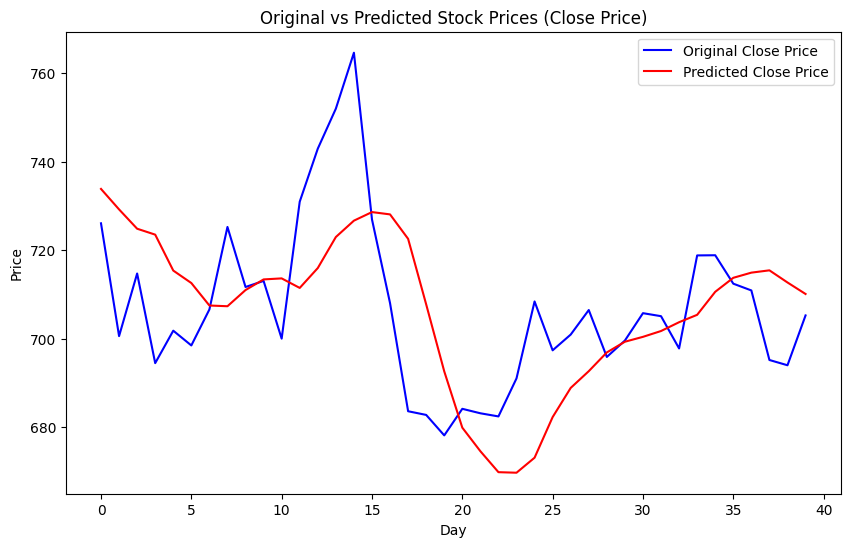

MSE:  245.4434412448528
RMSE:  15.666634649625708


In [46]:
model = Sequential([
    LSTM(25, activation='tanh', input_shape=(N, 5), return_sequences=False),
    Dense(M * 5) 
])

model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train.reshape(y_train.shape[0], -1),
    validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)
# Predictions
y_pred = model.predict(X_val)
y_pred = y_pred.reshape(y_pred.shape[0], M, 5)

y_val_inv = scaler.inverse_transform(pd.DataFrame(y_val.reshape(-1, 5), columns=columns))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 5))

# Plot original vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv[:40, 3], label="Original Close Price", color='blue')
plt.plot(y_pred_inv[:40, 3], label="Predicted Close Price", color='red')
plt.title("Original vs Predicted Stock Prices (Close Price)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()

mse = mean_squared_error(y_val_inv[:, 3], y_pred_inv[:, 3])
rmse = math.sqrt(mse)
print("MSE: ", mse)
print('RMSE: ', rmse)

### Hyperparameter tuned LSTM

Epoch 1/100


C:\Users\dhari\AppData\Local\Temp\ipykernel_108900\3162599089.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, verbose=1)


31/31 [==============================] - 1s 13ms/step - loss: 0.5116 - val_loss: 0.3890
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1802 - val_loss: 0.0565
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1437 - val_loss: 0.0471
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1365 - val_loss: 0.0466
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1296 - val_loss: 0.0437
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1253 - val_loss: 0.0444
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1214 - val_loss: 0.0391
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1170 - val_loss: 0.0402
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1183 - val_loss: 0.0413
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1152 - val_loss: 0.0365
Epoch 11/100
31/31 [

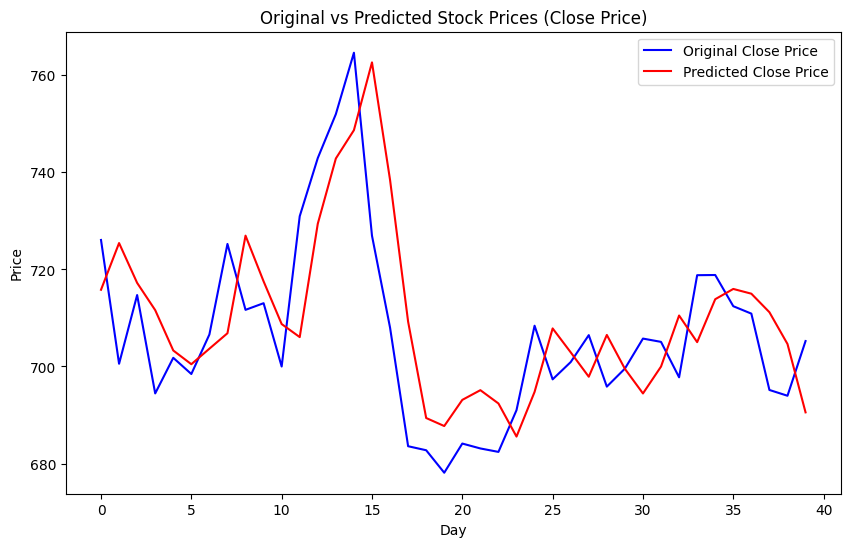

MSE:  156.84107346112066
RMSE:  12.523620621095189


In [47]:
def create_lstm_model(units=50, optimizer='adam', learning_rate=0.001):
    model = Sequential([
        LSTM(units, activation='tanh', input_shape=(N, 5), return_sequences=False),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(M * 5)
    ])
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse')
    return model

model = KerasRegressor(build_fn=create_lstm_model, verbose=1)

param_grid = {
    'units': [50,100,150],
    'learning_rate': [0.01,0.001,0.0001],
    'optimizer': ['adam', 'RMSprop'],
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [100],
    'callbacks': [EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=[(slice(None), slice(None))])
grid_search.fit(X_train, y_train.reshape(y_train.shape[0], -1), validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Predictions
y_pred = best_model.predict(X_val)
y_pred = y_pred.reshape(y_pred.shape[0], M, 5)

# Inverse transform predictions and ground truth
y_val_inv = scaler.inverse_transform(pd.DataFrame(y_val.reshape(-1, 5), columns=columns))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 5))

# Plot original vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv[:40, 3], label="Original Close Price", color='blue')
plt.plot(y_pred_inv[:40, 3], label="Predicted Close Price", color='red')
plt.title("Original vs Predicted Stock Prices (Close Price)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()

mse = mean_squared_error(y_val_inv[:, 3], y_pred_inv[:, 3])
rmse = math.sqrt(mse)
print("MSE: ", mse)
print('RMSE: ', rmse)

### Multilayer LSTM

C:\Users\dhari\AppData\Local\Temp\ipykernel_119856\3952741904.py:27: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_multilayer_lstm, verbose=1)


Epoch 1/100
31/31 [==============================] - 2s 21ms/step - loss: 0.7190 - val_loss: 1.0716
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.3027 - val_loss: 0.4307
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.1792 - val_loss: 0.1533
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.1612 - val_loss: 0.0699
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.1543 - val_loss: 0.0648
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 0.1522 - val_loss: 0.0599
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1502 - val_loss: 0.0599
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 0.1474 - val_loss: 0.0558
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1477 - val_loss: 0.0606
Epoch 10/100
31/31 [==============================] - 0s 7ms/step - loss: 0.1458 - val_loss: 0.0570
Epoch 11

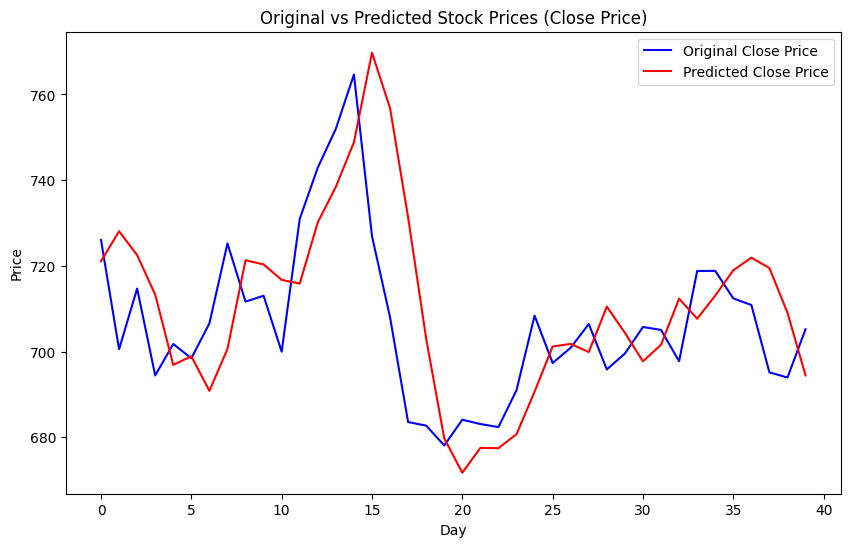

MSE:  143.8949491924159
RMSE:  11.995622084427964


In [41]:
def create_multilayer_lstm(units=50, activation='tanh', optimizer='adam', learning_rate=0.001, num_layers=0):
    model = Sequential()
    model.add(LSTM(units, activation=activation, input_shape=(N, 5), return_sequences=True))
    for _ in range(num_layers):
        model.add(LSTM(units, activation=activation, return_sequences=True))

    model.add(LSTM(units, activation=activation))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(M * 5))

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='mse')
    return model

model = KerasRegressor(build_fn=create_multilayer_lstm, verbose=1)

param_grid = {
    'units': [20, 50],
    'activation': ['tanh'],
    'optimizer': ['adam','RMSprop'],
    'learning_rate': [0.001, 0.01],  
    'epochs' : [100],
    'num_layers': [0],
    'callbacks': [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=[(slice(None), slice(None))])
grid_search.fit(X_train, y_train.reshape(y_train.shape[0], -1), validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Predictions
y_pred = best_model.predict(X_val)
y_pred = y_pred.reshape(y_pred.shape[0], M, 5)

y_val_inv = scaler.inverse_transform(pd.DataFrame(y_val.reshape(-1, 5), columns=columns))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 5))

# Plot original vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv[:40, 3], label="Original Close Price", color='blue')
plt.plot(y_pred_inv[:40, 3], label="Predicted Close Price", color='red')
plt.title("Original vs Predicted Stock Prices (Close Price)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()

mse = mean_squared_error(y_val_inv[:, 3], y_pred_inv[:, 3])
rmse = math.sqrt(mse)
print("MSE: ", mse)
print('RMSE: ', rmse)

## GRU

### Base GRU

Epoch 1/100
31/31 [==============================] - 1s 11ms/step - loss: 0.8550 - val_loss: 0.8369
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 0.4642 - val_loss: 0.4465
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2924 - val_loss: 0.2513
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2085 - val_loss: 0.1545
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1642 - val_loss: 0.1027
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1444 - val_loss: 0.0784
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1357 - val_loss: 0.0664
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1306 - val_loss: 0.0609
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1268 - val_loss: 0.0557
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1238 - val_loss: 0.0520
Epoch 11

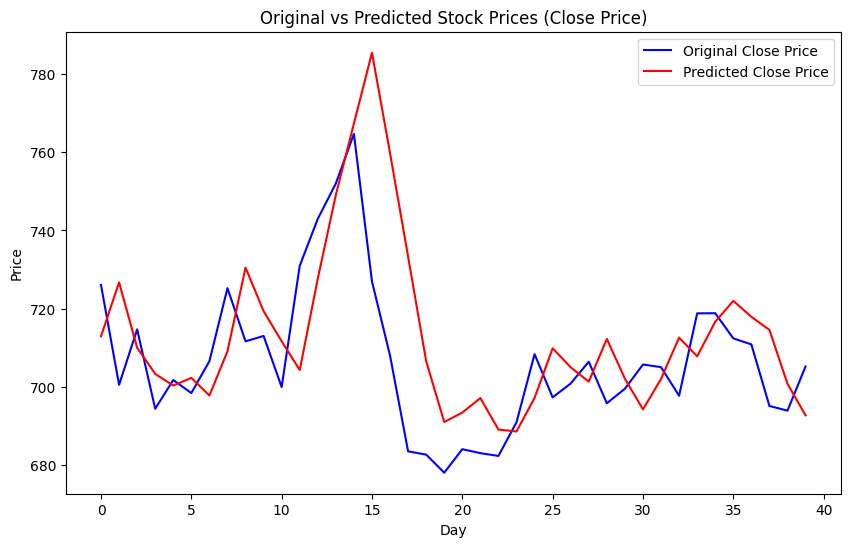

MSE:  128.42034334021278
RMSE:  11.332269999440218


In [51]:
model = Sequential([
    GRU(15, activation='tanh', input_shape=(N, 5)),
    Dense(M * 5)
])

model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train.reshape(y_train.shape[0], -1),
    validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Predictions
y_pred = model.predict(X_val)
y_pred = y_pred.reshape(y_pred.shape[0], M, 5)

# Inverse transform predictions and ground truth
y_val_inv = scaler.inverse_transform(pd.DataFrame(y_val.reshape(-1, 5), columns=columns))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 5))

# Plot original vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv[:40, 3], label="Original Close Price", color='blue')
plt.plot(y_pred_inv[:40, 3], label="Predicted Close Price", color='red')
plt.title("Original vs Predicted Stock Prices (Close Price)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()

mse = mean_squared_error(y_val_inv[:, 3], y_pred_inv[:, 3])
rmse = math.sqrt(mse)
print("MSE: ", mse)
print('RMSE: ', rmse)

### Hyperparameter tuned GRU

Epoch 1/100


C:\Users\dhari\AppData\Local\Temp\ipykernel_108900\3453695683.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_gru_model, verbose=1)


31/31 [==============================] - 2s 12ms/step - loss: 0.7117 - val_loss: 0.3382
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2201 - val_loss: 0.1329
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1397 - val_loss: 0.1088
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1235 - val_loss: 0.0877
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1173 - val_loss: 0.0677
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1133 - val_loss: 0.0570
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1119 - val_loss: 0.0513
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1112 - val_loss: 0.0560
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1074 - val_loss: 0.0483
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 0.1070 - val_loss: 0.0422
Epoch 11/100
31/31 [

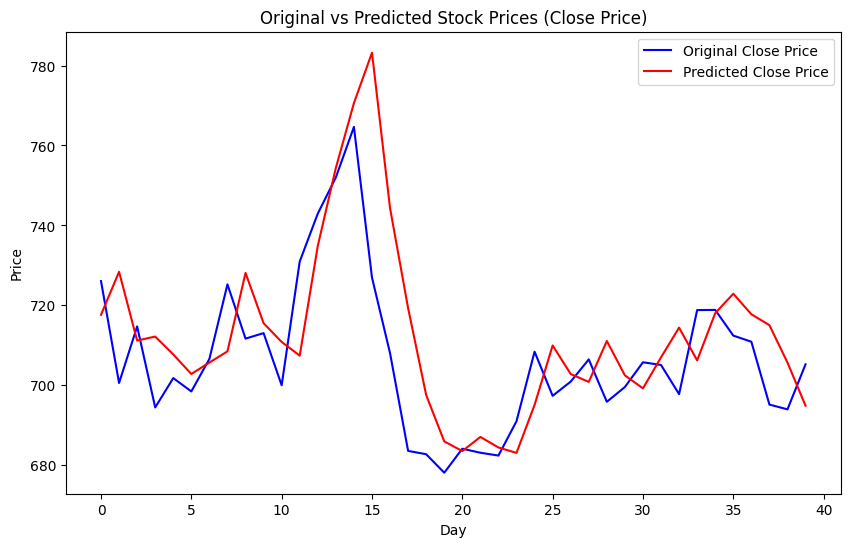

MSE:  120.46924796808383
RMSE:  10.975848394000522


In [52]:
def create_gru_model(units=50, optimizer='adam', learning_rate=0.001):
    model = Sequential([
        GRU(units, activation='tanh', input_shape=(N, 5), return_sequences=False),
        Dense(M * 5) 
    ])
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse')
    return model

model = KerasRegressor(build_fn=create_gru_model, verbose=1)

# Define the parameter grid
param_grid = {
    'units': [5, 10, 20, 30, 50, 100, 125],
    'learning_rate': [0.01,0.001,0.0001],
    'optimizer': ['adam', 'RMSprop'],
    'epochs': [100],
    'callbacks': [EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=[(slice(None), slice(None))])
grid_search.fit(X_train, y_train.reshape(y_train.shape[0], -1), validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Predictions
y_pred = best_model.predict(X_val)
y_pred = y_pred.reshape(y_pred.shape[0], M, 5)
y_val_inv = scaler.inverse_transform(pd.DataFrame(y_val.reshape(-1, 5), columns=columns))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 5))

# Plot original vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv[:40, 3], label="Original Close Price", color='blue')
plt.plot(y_pred_inv[:40, 3], label="Predicted Close Price", color='red')
plt.title("Original vs Predicted Stock Prices (Close Price)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()
mse = mean_squared_error(y_val_inv[:, 3], y_pred_inv[:, 3])
rmse = math.sqrt(mse)
print("MSE: ", mse)
print('RMSE: ', rmse)

### Multilayer GRU

C:\Users\dhari\AppData\Local\Temp\ipykernel_119856\1295147286.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_multilayer_gru, verbose=1)


Epoch 1/100
31/31 [==============================] - 3s 25ms/step - loss: 0.6540 - val_loss: 0.9717
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 0.2534 - val_loss: 0.2211
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 0.1528 - val_loss: 0.0678
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.1420 - val_loss: 0.0627
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 0.1379 - val_loss: 0.0551
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 0.1346 - val_loss: 0.0487
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 0.1304 - val_loss: 0.0464
Epoch 8/100
31/31 [==============================] - 0s 11ms/step - loss: 0.1254 - val_loss: 0.0452
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 0.1219 - val_loss: 0.0425
Epoch 10/100
31/31 [==============================] - 0s 11ms/step - loss: 0.1186 - val_loss: 0.0409

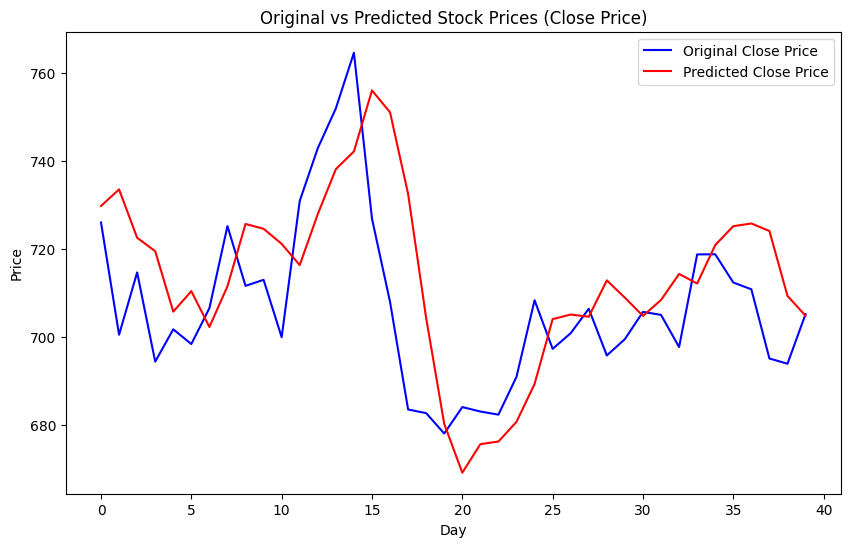

MSE:  143.641772955626
RMSE:  11.985064578700692


In [49]:
def create_multilayer_gru(units=50, activation='tanh', optimizer='adam', learning_rate=0.001, num_layers=0):
    model = Sequential()
    model.add(GRU(units, activation=activation, input_shape=(N, 5), return_sequences=True))
    for _ in range(num_layers):
        model.add(GRU(units, activation=activation, return_sequences=True))
    model.add(GRU(units, activation=activation))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(M * 5))
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='mse')
    return model

# Wrap the model using KerasRegressor for use with GridSearchCV
model = KerasRegressor(build_fn=create_multilayer_gru, verbose=1)

# Define the parameter grid
param_grid = {
    'units': [15,20,30],  
    'activation': ['tanh'],
    'optimizer': ['adam','RMSprop'],
    'learning_rate': [0.001, 0.01],
    'epochs' : [100],  
    'num_layers': [0],
    'callbacks': [EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=[(slice(None), slice(None))])
grid_search.fit(X_train, y_train.reshape(y_train.shape[0], -1), validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Predictions
y_pred = best_model.predict(X_val)
y_pred = y_pred.reshape(y_pred.shape[0], M, 5)

# Inverse transform predictions and ground truth
y_val_inv = scaler.inverse_transform(pd.DataFrame(y_val.reshape(-1, 5), columns=columns))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 5))

# Plot original vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv[:40, 3], label="Original Close Price", color='blue')
plt.plot(y_pred_inv[:40, 3], label="Predicted Close Price", color='red')
plt.title("Original vs Predicted Stock Prices (Close Price)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()
mse = mean_squared_error(y_val_inv[:, 3], y_pred_inv[:, 3])
rmse = math.sqrt(mse)
print("MSE: ", mse)
print('RMSE: ', rmse)

## Testing the model

Epoch 1/100
39/39 [==============================] - 1s 8ms/step - loss: 0.1465
Epoch 2/100
39/39 [==============================] - 0s 4ms/step - loss: 0.0930
Epoch 3/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0891
Epoch 4/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0867
Epoch 5/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0900
Epoch 6/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0872
Epoch 7/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0869
Epoch 8/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0848
Epoch 9/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0858
Epoch 10/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0873
Epoch 11/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0856
Epoch 12/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0839
Epoch 13/100
39/39 [=================

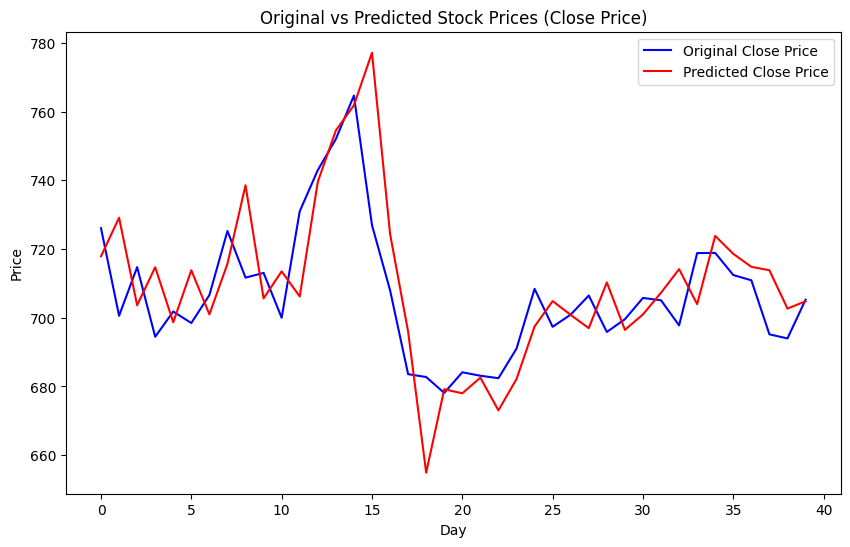

MSE:  111.38922324553579
RMSE:  10.554109306120331


In [80]:
model = Sequential([
    GRU(50, activation='tanh', input_shape=(N, 5)),
    Dense(M * 5)
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

early_stopping = EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    np.concatenate((X_train, X_val)), np.concatenate([y_train.reshape(y_train.shape[0], -1),y_val.reshape(y_val.shape[0], -1)]),
    epochs=100,
    callbacks=[early_stopping],
    verbose=1
)
# Predictions
y_pred = model.predict(X_val)
y_pred = y_pred.reshape(y_pred.shape[0], M, 5)


# Inverse transform predictions and ground truth
y_val_inv = scaler.inverse_transform(pd.DataFrame(y_val.reshape(-1, 5), columns=columns))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 5))

# Plot original vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_val_inv[:40, 3], label="Original Close Price", color='blue')
plt.plot(y_pred_inv[:40, 3], label="Predicted Close Price", color='red')
plt.title("Original vs Predicted Stock Prices (Close Price)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()

mse = mean_squared_error(y_val_inv[:, 3], y_pred_inv[:, 3])
rmse = math.sqrt(mse)
print("MSE: ", mse)
print('RMSE: ', rmse)

1/1 [==============================] - 0s 15ms/step


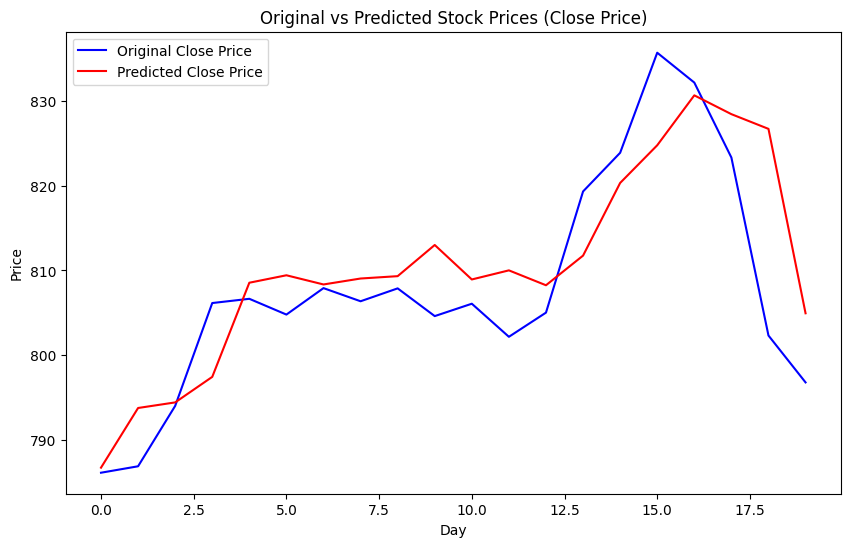

MSE:  59.30956571091549
RMSE:  7.701270395909723


In [83]:
# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0], M, 5)

# Inverse transform predictions and ground truth
y_test_inv = scaler.inverse_transform(pd.DataFrame(y_test.reshape(-1, 5), columns=columns))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 5))

# Plot original vs. predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv[:, 3], label="Original Close Price", color='blue')
plt.plot(y_pred_inv[:, 3], label="Predicted Close Price", color='red')
plt.title("Original vs Predicted Stock Prices (Close Price)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()

mse = mean_squared_error(y_test_inv[:, 3], y_pred_inv[:, 3])
rmse = math.sqrt(mse)
print("MSE: ", mse)
print('RMSE: ', rmse)